## Reading data and citing

https://nijianmo.github.io/amazon/index.html#sample-review

Justifying recommendations using distantly-labeled reviews and fined-grained aspects

Jianmo Ni, Jiacheng Li, Julian McAuley

Empirical Methods in Natural Language Processing (EMNLP), 2019

In [1]:
import pandas as pd
import json
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')
#Insert your filepath here to read the data:
filepath= 'C:/Users/slopp/Desktop/Data Analytics 2023/Kindle_Store_5.json.gz'
df = getDF(filepath)
print("Data Loading Complete.")

Data Loading Complete.


In [2]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,4.0,True,"07 3, 2014",A2LSKD2H9U8N0J,B000FA5KK0,{'Format:': ' Kindle Edition'},sandra sue marsolek,"pretty good story, a little exaggerated, but I...",pretty good story,1404345600,NaN,NaN
1,5.0,True,"05 26, 2014",A2QP13XTJND1QS,B000FA5KK0,{'Format:': ' Kindle Edition'},Tpl,"If you've read other max brand westerns, you k...",A very good book,1401062400,NaN,NaN
2,5.0,True,"09 16, 2016",A8WQ7MAG3HFOZ,B000FA5KK0,{'Format:': ' Kindle Edition'},Alverne F. Anderson,"Love Max, always a fun twist",Five Stars,1473984000,NaN,NaN
3,5.0,True,"03 3, 2016",A1E0MODSRYP7O,B000FA5KK0,{'Format:': ' Kindle Edition'},Jeff,"As usual for him, a good book",a good,1456963200,NaN,NaN
4,5.0,True,"09 10, 2015",AYUTCGVSM1H7T,B000FA5KK0,{'Format:': ' Kindle Edition'},DEHS - EddyRapcon,MB is one of the original western writers and ...,A Western,1441843200,2,NaN


In [3]:
ids = df['reviewerID'].unique()
ids

array(['A2LSKD2H9U8N0J', 'A2QP13XTJND1QS', 'A8WQ7MAG3HFOZ', ...,
       'A1S5LS59NANC9R', 'A1SR1SZA08EP2V', 'A3I36S1KLJE1H6'], dtype=object)

In [4]:
df.shape

(2222983, 12)

In [5]:
df.isna().sum()

overall                 0
verified                0
reviewTime              0
reviewerID              0
asin                    0
style               52617
reviewerName          127
reviewText            403
summary              1755
unixReviewTime          0
vote              1931032
image             2221618
dtype: int64

Lets look at NA values:
- Missing reviewerName is fine as long as reviewerID exists
- Missing reviewText: do we care? does it contain useful info? I think we can remove reviews without text. Very small subsection of dataset.
- Missing summary can also be removed. Another very small prcentage of the data.
- Missing vote is fine, not everyone gets helpfulness votes. We should represent an NA helpfulness vote as 0.
- Weird that some people include images for kindle reviews. Can honestly drop image altogether as a variable.
- Let's look at the missing style. Dictionary unfortunately!

In [6]:
#This helps us turn our dictionary of styles into a dataframe.
styles = pd.json_normalize(df['style'])

In [7]:
print(styles['Format:'].unique())
#"Kindle Edition" should be the only one.
kindle = styles.loc[styles['Format:']==' Kindle Edition']
kindle.shape
#Anything that isn't kindle edition needs to be nixed!

[' Kindle Edition' ' Hardcover' ' Mass Market Paperback' nan ' Paperback'
 ' 3.5" disk' ' Audible Audiobook' ' Audio CD' ' Audio Cassette'
 ' Library Binding' ' Kindle Edition with Audio/Video' ' MP3 CD'
 ' Leather Bound' ' Print Magazine' ' Perfect Paperback'
 ' School & Library Binding' ' Digital' ' Board book' ' Flexibound'
 ' Imitation Leather' ' Unknown Binding' ' Prime Video' ' DVD'
 ' Preloaded Digital Audio Player' ' VHS Tape' ' CD-ROM' ' Comic']


(2141350, 1)

In [8]:
#Only use row indices that are in list of 
df2 = df[df.index.isin(kindle.index)]
df2.shape
#Takes care of all NA and styles that aren't equal to Kindle Edition.
#This removes potential misidentified products and/or duplicates.

(2141350, 12)

In [9]:
df2.isna().sum()

overall                 0
verified                0
reviewTime              0
reviewerID              0
asin                    0
style                   0
reviewerName          124
reviewText            378
summary              1725
unixReviewTime          0
vote              1861859
image             2140182
dtype: int64

In [10]:
df2['reviewText'].dropna()
df2['summary'].dropna()

0                                   pretty good story
1                                    A very good book
2                                          Five Stars
3                                              a good
4                                           A Western
                              ...                    
2222978                                     Cool book
2222979                                    Crazy Read
2222980                                      Loved it
2222981                              Beautiful ending
2222982    Glad Tuesday received her happy ever after
Name: summary, Length: 2139625, dtype: object

## Creating the dataframe

For each reviewer, I want to know:

- n reviews
- Number of helpfulness votes (sum(vote))
- mean(overall)
- median(overall)
- min(overall)
- max(overall)
- mean review character length
- median review character length
- max review character length
- min review character length
- Fastest time between reviews if possible (shortest distance between unixreviewtime)

In [11]:
df2['reviewLength'] = df2['reviewText'].str.len()
print(len(df2['reviewText'][0]), df2['reviewLength'][0])
#Numbers line up!

205 205.0


C:\Users\slopp\AppData\Local\Temp\ipykernel_15804\4133055103.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['reviewLength'] = df2['reviewText'].str.len()


In [12]:
df2['summaryLength'] = df2['summary'].str.len()
#Maybe capital letters in review? Or percent of letters in review that are capital? Could indicate angry or old.
#Something to consider for later.

C:\Users\slopp\AppData\Local\Temp\ipykernel_15804\907061788.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['summaryLength'] = df2['summary'].str.len()


In [13]:
vote_counts = df2['vote'].unique()
for i in vote_counts:
    print(i)
#Dreaded nan and a comma! We must deal w it.

nan
2
3
5
8
4
12
49
10
7
9
6
222
68
28
14
61
126
50
35
15
13
16
21
11
177
19
18
25
20
17
22
24
45
29
48
128
56
67
31
137
39
26
100
34
78
85
47
27
96
51
52
82
469
46
23
72
131
32
33
40
30
62
57
195
471
99
167
104
230
189
122
54
43
80
37
42
41
38
213
55
63
70
107
73
69
130
297
77
94
83
44
91
74
79
60
88
36
283
105
92
165
139
53
65
134
223
136
98
87
59
135
66
124
384
76
58
265
133
89
151
106
212
153
409
64
294
175
84
86
110
81
103
181
71
199
116
114
75
147
97
112
150
170
166
209
159
205
119
289
307
158
152
102
108
90
95
129
374
113
101
206
145
115
193
990
677
132
204
93
178
171
127
241
123
141
146
187
111
154
183
179
256
185
261
109
121
207
138
125
162
163
323
172
377
2,228
142
168
273
161
176
201
211
117
255
143
411
173
229
160
434
360
274
149
285
291
260
144
296
614
120
275
378
712
650
198
437
186
271
246
451
269
537
342
226
220
188
157
180


In [14]:
df2.loc[df2['vote']=="2,228", 'vote'] = "2228"
df2.loc[df2['vote'].isna(), 'vote'] = "0"
df2['vote'] = pd.to_numeric(df2['vote'])
df2['vote']

C:\Users\slopp\AppData\Local\Temp\ipykernel_15804\3129049560.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['vote'] = pd.to_numeric(df2['vote'])


0          0
1          0
2          0
3          0
4          2
          ..
2222978    0
2222979    0
2222980    0
2222981    0
2222982    0
Name: vote, Length: 2141350, dtype: int64

In [15]:
df2.describe()

,overall,unixReviewTime,vote,reviewLength,summaryLength
count,2.141350e+06,2.141350e+06,2.141350e+06,2.140972e+06,2.139625e+06
mean,4.397912e+00,1.433833e+09,6.101408e-01,5.045068e+02,2.407097e+01
std,9.227837e-01,4.287517e+07,3.852545e+00,6.695202e+02,1.929808e+01
min,1.000000e+00,1.184803e+09,0.000000e+00,1.000000e+00,1.000000e+00
25%,4.000000e+00,1.405382e+09,0.000000e+00,1.370000e+02,1.000000e+01
50%,5.000000e+00,1.435190e+09,0.000000e+00,2.660000e+02,1.800000e+01
75%,5.000000e+00,1.462493e+09,0.000000e+00,5.960000e+02,3.100000e+01
max,5.000000e+00,1.538525e+09,2.228000e+03,3.000000e+04,7.280000e+02


In [16]:
#Time to create the df?
#takes a series called numbers
#This will take in unix time and find the minimum time gap between review postings in seconds.
def min_gap(numbers):
    #Order list, lag by 1, then take minimum of lags
    #s = numbers.sort()
    #s= sorted(numbers)
    if numbers.size==1:
        return -1
    #-1 indicates a sample size of 1, only 1 review in dataset
    else:
        s= numbers.sort_values()
        d=[]
        for i in range(1, s.size):
            diff= s.iloc[-i]-s.iloc[-(i+1)]
            d.append(diff)
        return min(d)
l=[1,2,56,77,89,15,17,82]
ser = pd.Series(l, copy=False)
min_gap(ser) #Works!

1

In [17]:
df2.dtypes

overall           float64
verified             bool
reviewTime         object
reviewerID         object
asin               object
style              object
reviewerName       object
reviewText         object
summary            object
unixReviewTime      int64
vote                int64
image              object
reviewLength      float64
summaryLength     float64
dtype: object

In [18]:
temp = df2.head().groupby('reviewerID').aggregate({'unixReviewTime' : min_gap})
temp.head()
temp = df2.groupby('reviewerID', sort=False).aggregate({'unixReviewTime' : min_gap})

In [19]:
temp.loc[temp['unixReviewTime'] > 60]
#It works!

,unixReviewTime
reviewerID,
A2RW1CXT3XSLXW,259200
AQZH7YTWQPOBE,1555200
A22CW0ZHY3NJH8,1555200
A454MD2H0729Q,3542400
A27Q7QKHCP20CX,518400
...,...
A3UJDMFNSWPKL4,2073600
A100EA3NTJPR6C,86400
A5LCI16ZLTVO8,691200


In [20]:
reviewer_agg = (df2.groupby('reviewerID', sort=False)
                .aggregate({'unixReviewTime' : min_gap,
                           'overall' : ['max', 'min', 'median', 'mean'],
                           #'overall' : 'min',
                           #'overall' : 'mean',
                           #'overall' : 'median',
                           'reviewLength' : ['max', 'min', 'median', 'mean'],
                           #'reviewLength' : 'min',
                           #'reviewLength' : 'mean',
                           #'reviewLength' : 'median',
                           'summaryLength' : ['max', 'min', 'median', 'mean'],
                           #'summaryLength' : 'min',
                           #'summaryLength' : 'mean',
                           #'summaryLength' : 'median',
                           'vote' : 'sum',
                           'reviewerID' : 'count',
                           'verified' : 'mean'
                           })
               )#Ends daisy chain
#Want to squish from multilevel colnames to single level:
cols = reviewer_agg.columns.get_level_values(0)+"_"+reviewer_agg.columns.get_level_values(1)
reviewer_agg.columns= cols
reviewer_agg.dropna()
reviewer_agg

,unixReviewTime_min_gap,overall_max,overall_min,overall_median,overall_mean,reviewLength_max,reviewLength_min,reviewLength_median,reviewLength_mean,summaryLength_max,summaryLength_min,summaryLength_median,summaryLength_mean,vote_sum,reviewerID_count,verified_mean
reviewerID,,,,,,,,,,,,,,,,
A2LSKD2H9U8N0J,0,5.0,2.0,4.0,3.742857,205.0,47.0,106.0,107.742857,56.0,9.0,17.0,20.828571,2,35,1.000000
A2QP13XTJND1QS,0,5.0,1.0,5.0,4.533333,196.0,98.0,125.0,130.133333,42.0,7.0,16.0,20.466667,8,15,1.000000
A8WQ7MAG3HFOZ,0,5.0,4.0,5.0,4.571429,127.0,7.0,28.0,37.285714,15.0,10.0,10.0,10.714286,0,7,1.000000
A1E0MODSRYP7O,0,5.0,4.0,5.0,4.958333,38.0,4.0,12.0,14.208333,10.0,6.0,10.0,9.833333,0,24,0.541667
AYUTCGVSM1H7T,0,5.0,3.0,5.0,4.921960,963.0,130.0,302.0,309.228675,148.0,4.0,43.0,43.457350,205,551,0.882033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A2475CJ29322LB,0,5.0,5.0,5.0,5.000000,124.0,8.0,28.0,47.800000,16.0,10.0,10.0,11.200000,0,5,0.400000
A1S5LS59NANC9R,0,5.0,5.0,5.0,5.000000,425.0,134.0,211.0,244.800000,68.0,12.0,30.0,32.600000,0,5,1.000000
A3UI1NKH4EN8DV,-1,4.0,4.0,4.0,4.000000,218.0,218.0,218.0,218.000000,57.0,57.0,57.0,57.000000,0,1,0.000000


In [21]:
#This begs the question... are there duplicates? Why are all these reviews being posted at the same time?
df2.loc[df2['reviewerID']=="A2475CJ29322LB"]
#Oh... Unix review time as recorded is not accurate to the second, it only records the DATE of posting....
#Shame. Oh well, though. Still useful in some ways.

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image,reviewLength,summaryLength
2196899,5.0,True,"01 5, 2017",A2475CJ29322LB,B01EP2NBEA,{'Format:': ' Kindle Edition'},Amazon Customer,its very good and addictive,Five Stars,1483574400,0,NaN,27.0,10.0
2201057,5.0,True,"07 18, 2016",A2475CJ29322LB,B01F4A9XQC,{'Format:': ' Kindle Edition'},Amazon Customer,I loved the book. I've been trying to read on...,I loved the book,1468800000,0,NaN,124.0,16.0
2205363,5.0,False,"01 5, 2017",A2475CJ29322LB,B01FOMXX02,{'Format:': ' Kindle Edition'},Amazon Customer,It is an extremely well written. its also add...,Five Stars,1483574400,0,NaN,52.0,10.0
2207545,5.0,False,"01 23, 2017",A2475CJ29322LB,B01FWGVRHG,{'Format:': ' Kindle Edition'},Amazon Customer,the entire series was awsome,Five Stars,1485129600,0,NaN,28.0,10.0
2222470,5.0,False,"01 23, 2017",A2475CJ29322LB,B01HHDUTNU,{'Format:': ' Kindle Edition'},Amazon Customer,loved it,Five Stars,1485129600,0,NaN,8.0,10.0


In [22]:
reviewer_agg.describe()

,unixReviewTime_min_gap,overall_max,overall_min,overall_median,overall_mean,reviewLength_max,reviewLength_min,reviewLength_median,reviewLength_mean,summaryLength_max,summaryLength_min,summaryLength_median,summaryLength_mean,vote_sum,reviewerID_count,verified_mean
count,1.391770e+05,139177.000000,139177.000000,139177.000000,139177.000000,139170.000000,139170.000000,139170.000000,139170.000000,139173.000000,139173.000000,139173.000000,139173.000000,139177.000000,139177.000000,139177.000000
mean,9.997114e+05,4.922509,3.236418,4.519202,4.369424,824.862585,150.281217,357.841097,394.240661,48.370740,9.880307,20.638766,23.388272,9.387507,15.385804,0.719593
std,4.181036e+06,0.318939,1.358380,0.743072,0.652865,1068.758269,240.982894,462.900559,475.650828,28.359537,6.545319,12.383248,12.205099,34.187998,29.274177,0.329040
min,-1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.857143,0.000000,1.000000,0.000000
25%,0.000000e+00,5.000000,2.000000,4.000000,4.000000,240.000000,39.000000,128.000000,141.135714,27.000000,6.000000,11.000000,14.600000,0.000000,5.000000,0.500000
50%,0.000000e+00,5.000000,3.000000,5.000000,4.555556,464.000000,105.000000,207.000000,237.600000,43.000000,9.000000,17.000000,20.708333,2.000000,8.000000,0.852941
75%,5.184000e+05,5.000000,4.000000,5.000000,4.900000,967.000000,154.000000,404.000000,458.180556,63.000000,11.000000,26.000000,29.095238,7.000000,14.000000,1.000000
max,2.007936e+08,5.000000,5.000000,5.000000,5.000000,30000.000000,25717.000000,29985.000000,25760.333333,728.000000,128.000000,132.500000,160.600000,2546.000000,1366.000000,1.000000


In [23]:
#I think we should drop the medians, as being resistant might tell us less and they will be highly correlated w mean 
#(or equal to mean in some cases)
#We should also drop cases where each individual's n < 5. 
reviewer_agg.size

2226832

In [24]:
reviewer_agg.drop(columns=['overall_median', 'reviewLength_median', 'summaryLength_median'], inplace=True)

In [25]:
reviewer_agg = reviewer_agg.loc[reviewer_agg['reviewerID_count'] >= 5]
reviewer_agg.size
#Dropped a TON of variables. I think this will be okay for the sake of our analysis goals.
#It will be impossible to determine if someone is a power user or a bot based on just one review alone.
#It will probably be hard for 5 reviews as well, but whatever.

1721733

In [26]:
df = reviewer_agg.copy(deep=True)
#Deep copy so I can call df instead of reviewer_agg :P
#Each distribution will be incredibly skewed.
print(df.describe())
#Why is count different for summary and review length?

       unixReviewTime_min_gap    overall_max    overall_min   overall_mean  \
count            1.324410e+05  132441.000000  132441.000000  132441.000000   
mean             7.201057e+05       4.932581       3.219298       4.376669   
std              1.964482e+06       0.289385       1.358549       0.642109   
min              0.000000e+00       1.000000       1.000000       1.000000   
25%              0.000000e+00       5.000000       2.000000       4.000000   
50%              0.000000e+00       5.000000       3.000000       4.566667   
75%              5.184000e+05       5.000000       4.000000       4.888889   
max              4.164480e+07       5.000000       5.000000       5.000000   

       reviewLength_max  reviewLength_min  reviewLength_mean  \
count     132435.000000     132435.000000      132435.000000   
mean         831.569661        142.606954         390.006125   
std         1075.956956        213.182133         463.679694   
min            1.000000          1.000000

In [27]:
df.loc[df['reviewLength_max'].isna()]
#Weird. For some reason, there are 5 obs where we were unable to parse review  length, even after
#Dropping the NA values. 
#there is 1 value where we can't parse either summary or review length,
#Which leaves some values where we could parse review but not summary. maybe there's something in how
#python counts characters?

,unixReviewTime_min_gap,overall_max,overall_min,overall_mean,reviewLength_max,reviewLength_min,reviewLength_mean,summaryLength_max,summaryLength_min,summaryLength_mean,vote_sum,reviewerID_count,verified_mean
reviewerID,,,,,,,,,,,,,
A2IXB5P9Y3GOS7,0,5.0,5.0,5.000000,NaN,NaN,NaN,10.0,10.0,10.0,0,10,1.000000
APTF70P0QII0D,0,5.0,5.0,5.000000,NaN,NaN,NaN,10.0,10.0,10.0,0,10,1.000000
A129RVPFX46MQE,0,5.0,4.0,4.800000,NaN,NaN,NaN,10.0,10.0,10.0,0,5,1.000000
A32BRQNUV4H2PW,0,5.0,5.0,5.000000,NaN,NaN,NaN,10.0,10.0,10.0,0,6,1.000000
A1GTUNWZRCLRKL,1209600,5.0,4.0,4.666667,NaN,NaN,NaN,10.0,10.0,10.0,0,6,0.166667
A2FS25H62WP8JM,0,5.0,5.0,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,0,5,1.000000


In [28]:
df = df.loc[df['reviewLength_max'].notna()]
df = df.loc[df['summaryLength_max'].notna()]
print(df.describe())
#Dropped those values.

       unixReviewTime_min_gap    overall_max    overall_min   overall_mean  \
count            1.324320e+05  132432.000000  132432.000000  132432.000000   
mean             7.201409e+05       4.932577       3.219222       4.376642   
std              1.964542e+06       0.289394       1.358548       0.642118   
min              0.000000e+00       1.000000       1.000000       1.000000   
25%              0.000000e+00       5.000000       2.000000       4.000000   
50%              0.000000e+00       5.000000       3.000000       4.566667   
75%              5.184000e+05       5.000000       4.000000       4.888889   
max              4.164480e+07       5.000000       5.000000       5.000000   

       reviewLength_max  reviewLength_min  reviewLength_mean  \
count     132432.000000     132432.000000      132432.000000   
mean         831.582775        142.608539         390.011133   
std         1075.965379        213.184153         463.683360   
min            1.000000          1.000000

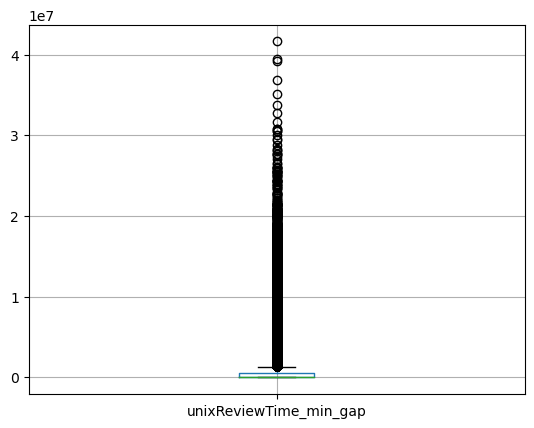

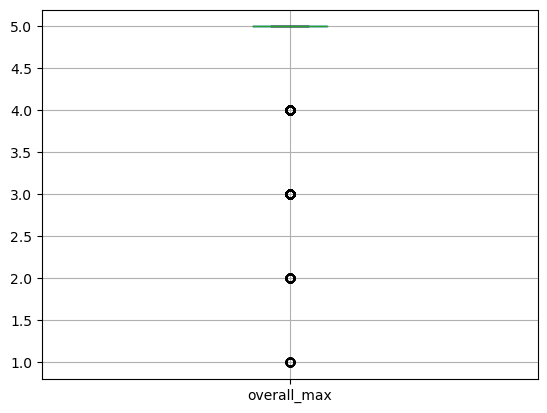

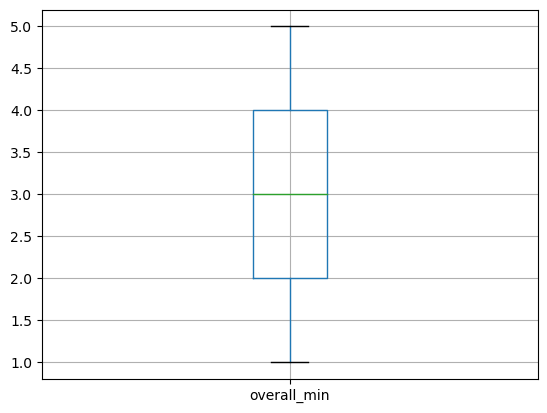

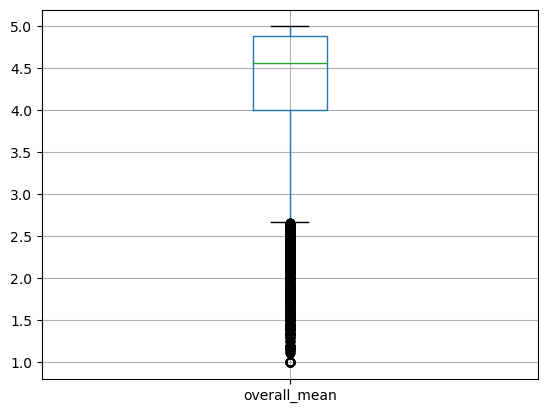

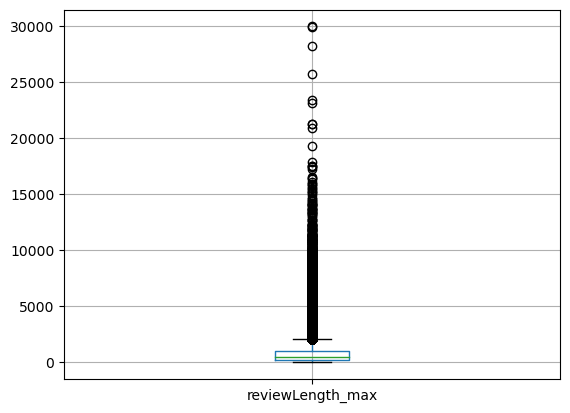

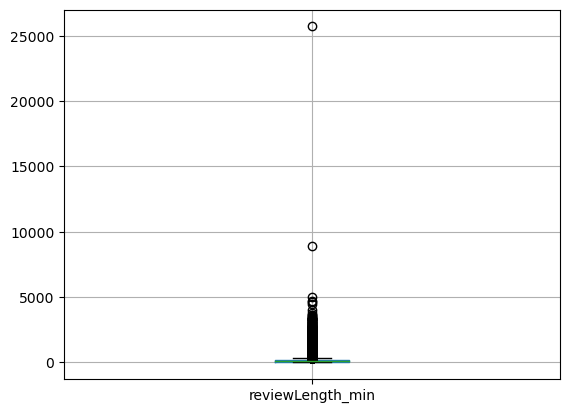

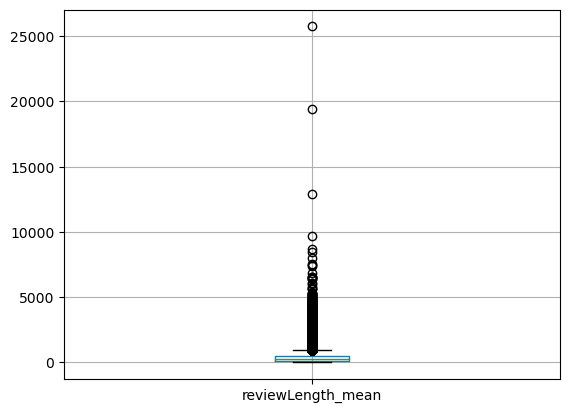

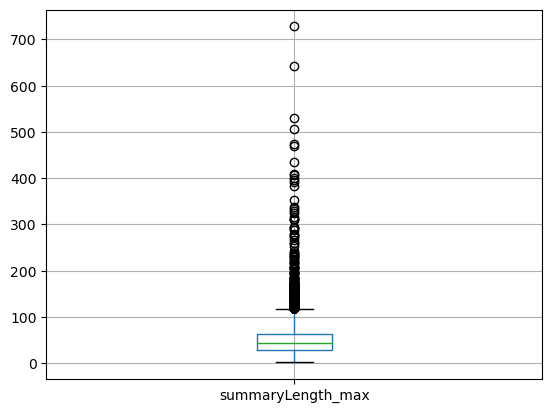

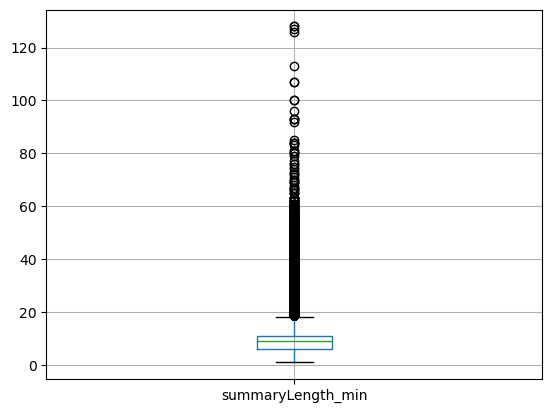

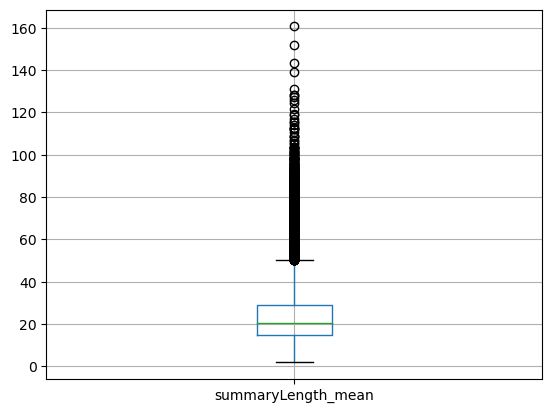

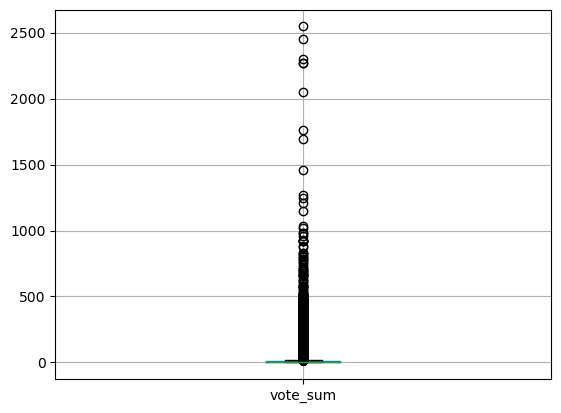

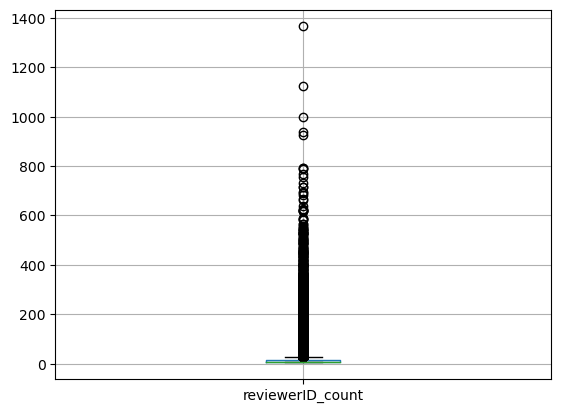

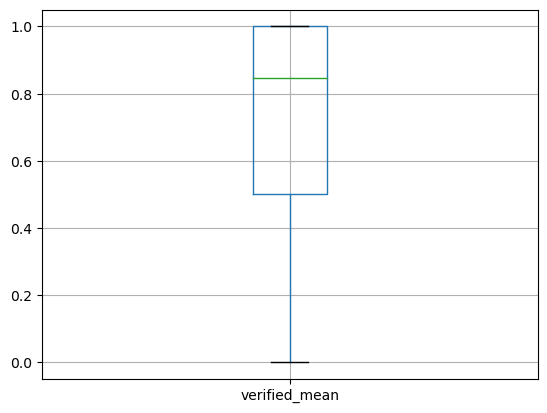

In [29]:
import matplotlib.pyplot as plt
# Code from https://stackoverflow.com/questions/51777217/how-to-plot-a-boxplot-for-each-column-in-a-dataframe
#plt.figure() resets the plotting so we can iterate over columns 
for column in df:
    plt.figure()
    df.boxplot([column])

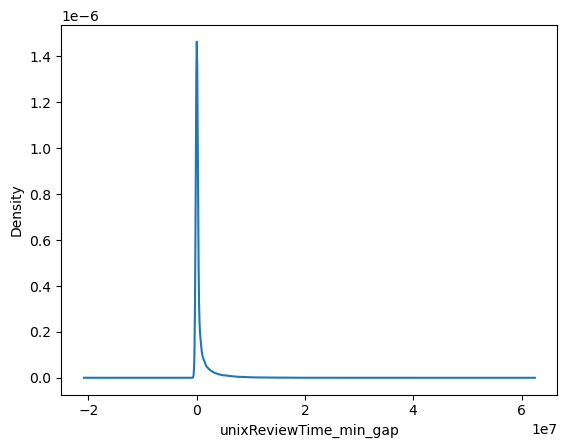

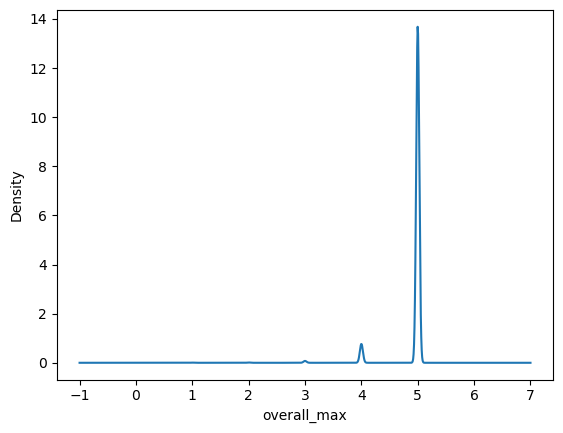

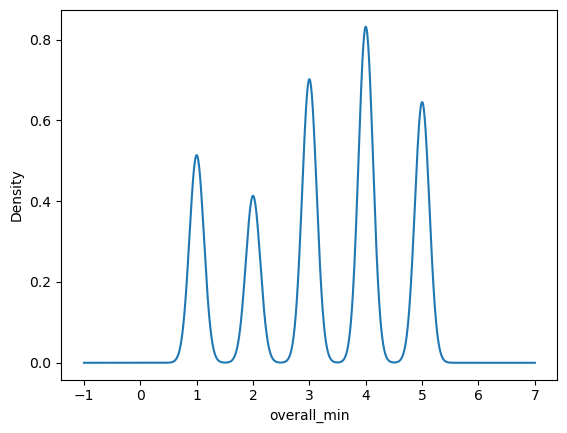

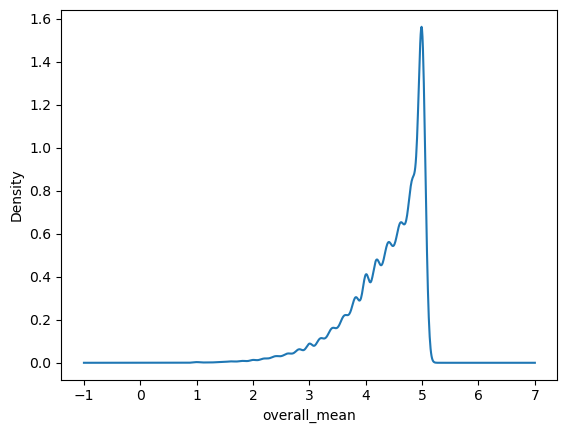

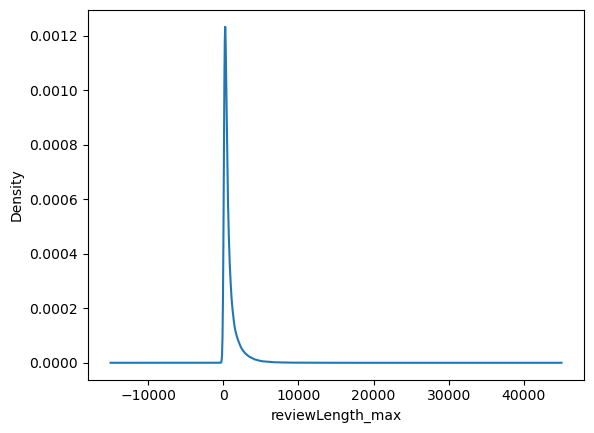

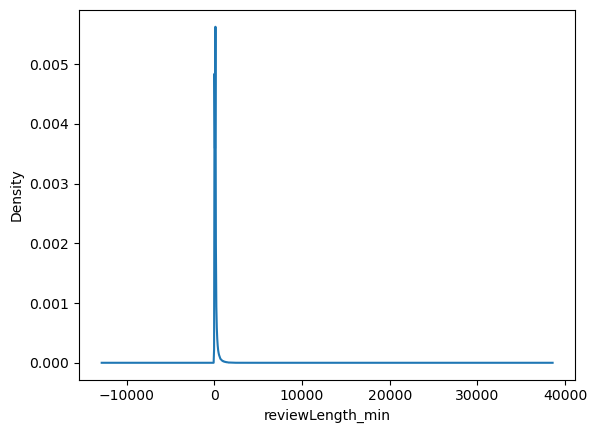

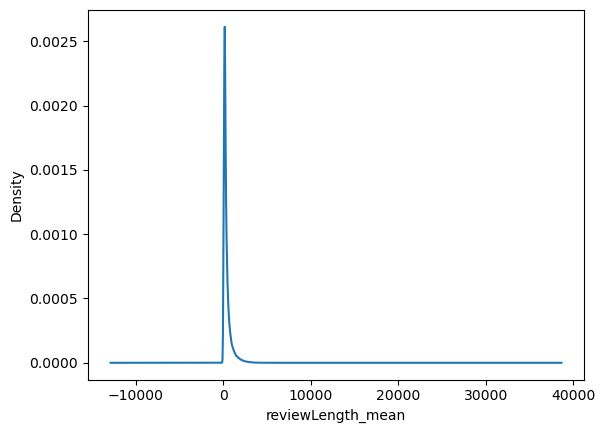

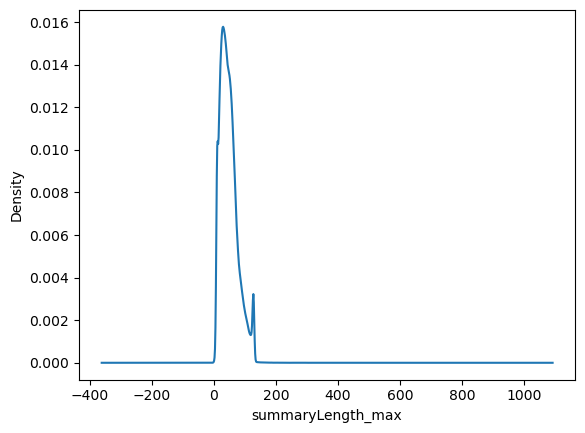

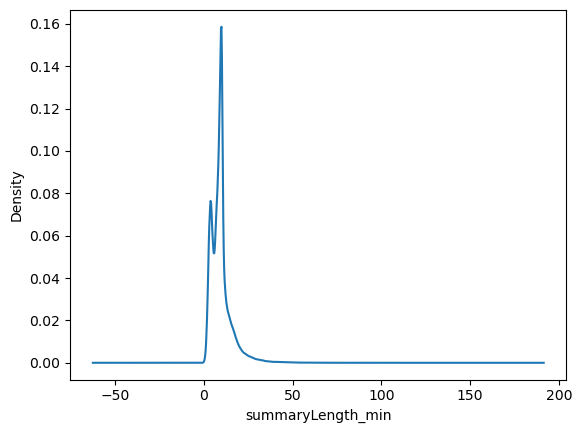

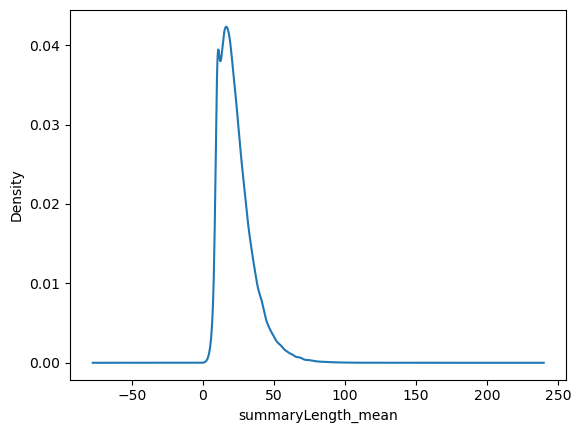

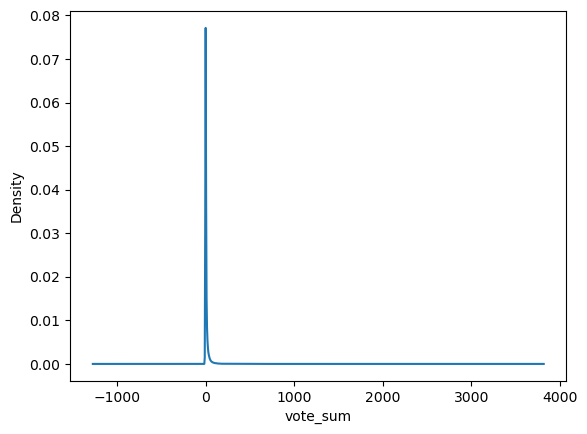

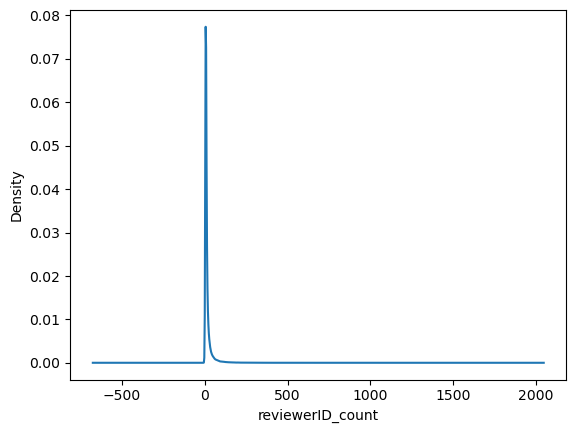

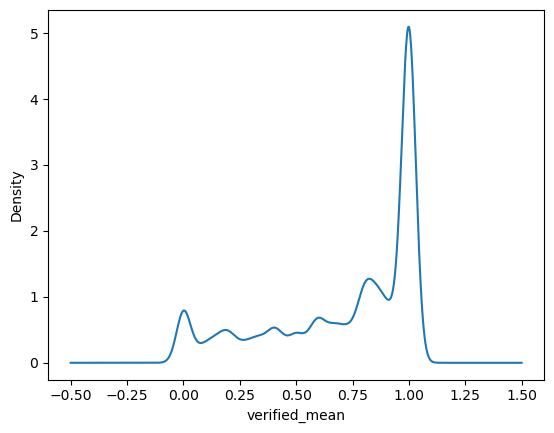

In [30]:
for column in df:
    plt.figure()
    df[column].plot.density()
    plt.xlabel(column)

<AxesSubplot:>

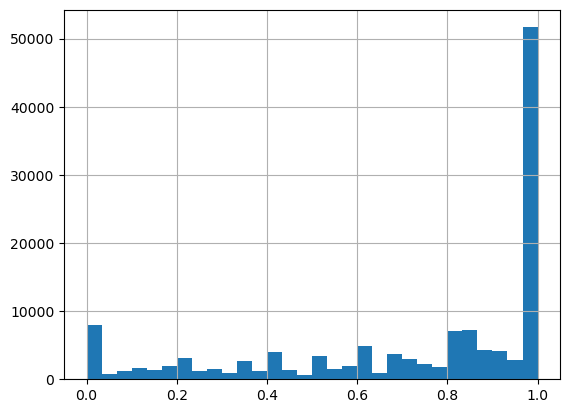

In [31]:
df['verified_mean'].hist(bins=30)

<AxesSubplot:>

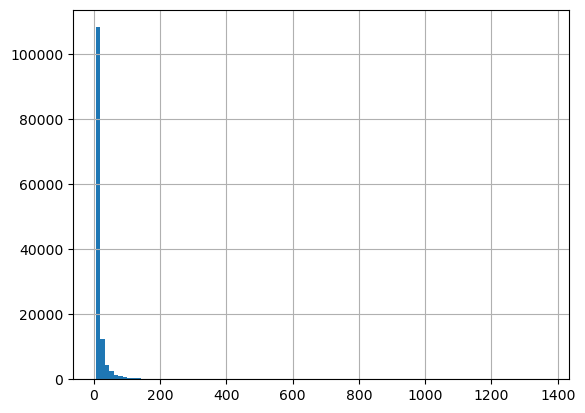

In [32]:
df['reviewerID_count'].hist(bins=100)

<AxesSubplot:>

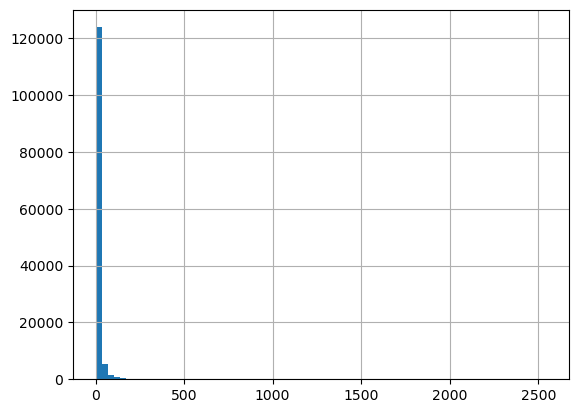

In [33]:
df['vote_sum'].hist(bins=75)

<AxesSubplot:>

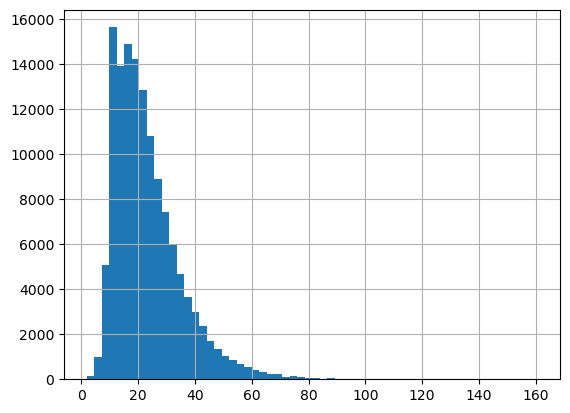

In [34]:
df['summaryLength_mean'].hist(bins=60)

<AxesSubplot:>

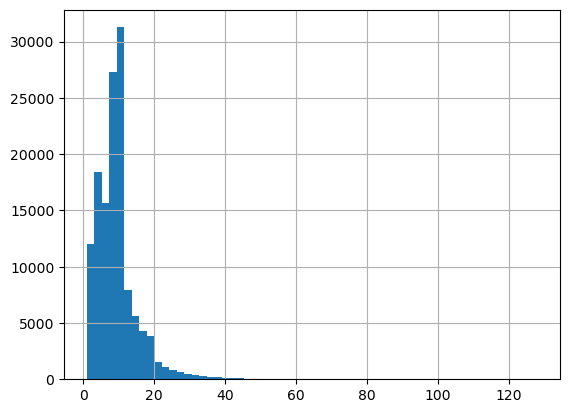

In [35]:
df['summaryLength_min'].hist(bins=60)

<AxesSubplot:>

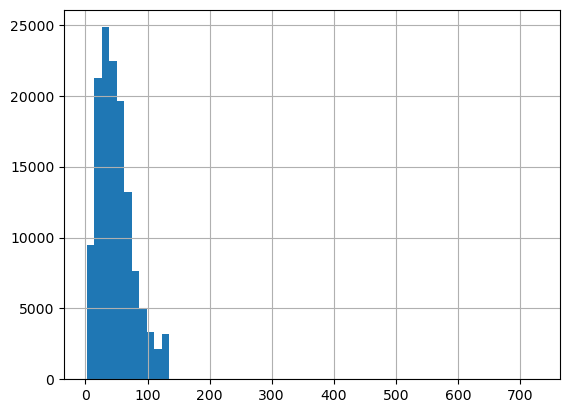

In [36]:
df['summaryLength_max'].hist(bins=60)

<AxesSubplot:>

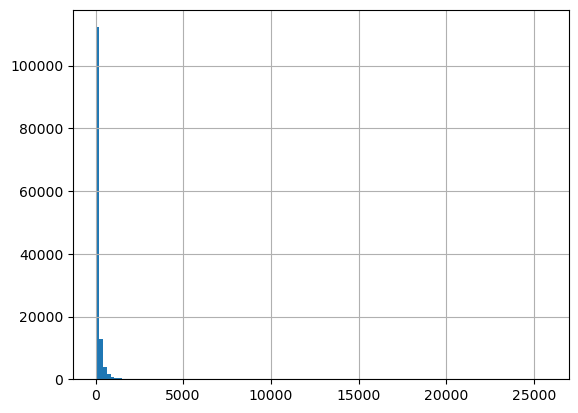

In [37]:
df['reviewLength_min'].hist(bins=120)

<AxesSubplot:>

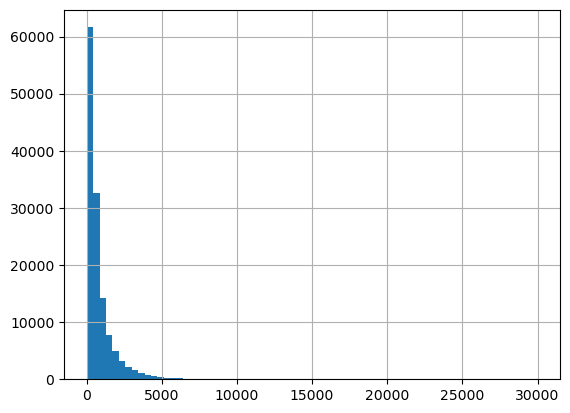

In [38]:
df['reviewLength_max'].hist(bins=70)

<AxesSubplot:>

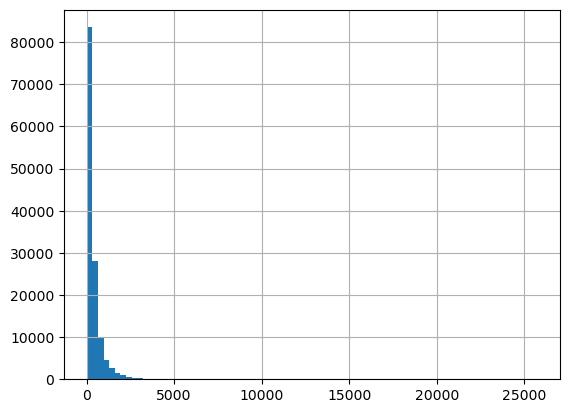

In [39]:
df['reviewLength_mean'].hist(bins=80)

<AxesSubplot:>

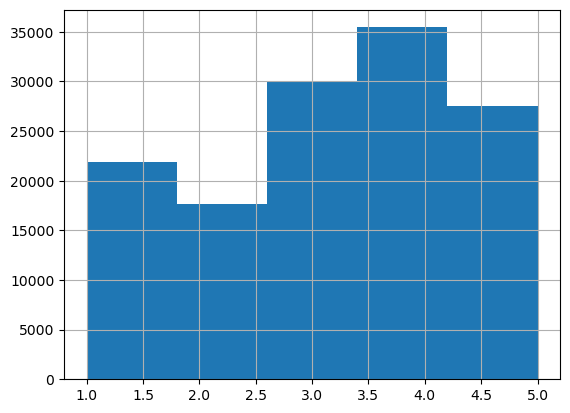

In [40]:
df['overall_min'].hist(bins=5)

<AxesSubplot:>

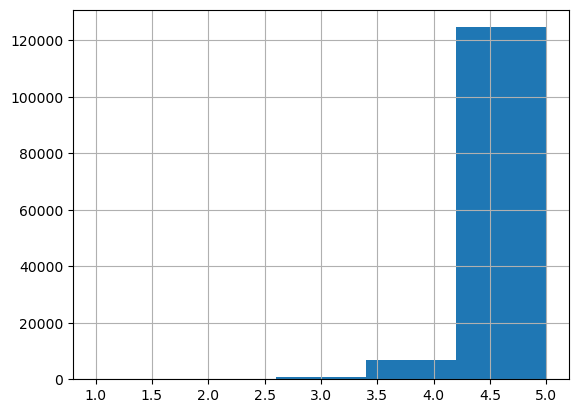

In [41]:
df['overall_max'].hist(bins=5)

<AxesSubplot:>

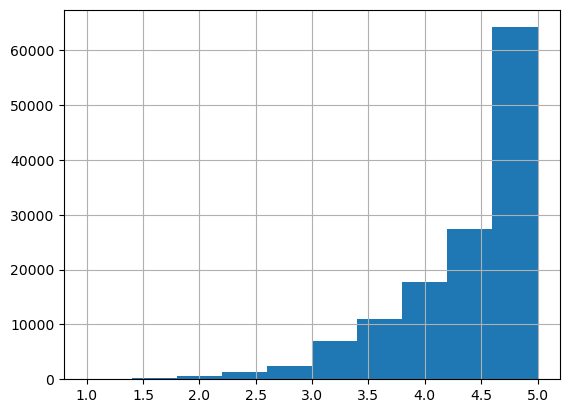

In [42]:
df['overall_mean'].hist(bins=10)

<AxesSubplot:>

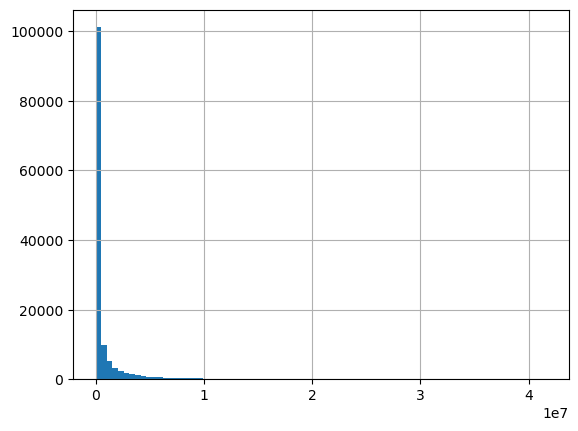

In [43]:
df['unixReviewTime_min_gap'].hist(bins=80)

use minmax scaler

Use hierarchial clustering

Github repos may be messed up for dendogram examples 

Now, it's time to scale our data using a minmax scaler. Because our data does not follow any particular distribution and there are some issues with normalizing (highly skewed distributions with some well-defined mins and maxes that censor one side of the data), minmax is appropriate.

In [44]:
from sklearn.preprocessing import MinMaxScaler
#I will use the minmax scaler here
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
#df_scaled.rename(columns=)
#print()

In [45]:
df_scaled.describe()

,unixReviewTime_min_gap,overall_max,overall_min,overall_mean,reviewLength_max,reviewLength_min,reviewLength_mean,summaryLength_max,summaryLength_min,summaryLength_mean,vote_sum,reviewerID_count,verified_mean
count,132432.000000,132432.000000,132432.000000,132432.000000,132432.000000,132432.000000,132432.000000,132432.000000,132432.000000,132432.000000,132432.000000,132432.000000,132432.000000
mean,0.017292,0.983144,0.554805,0.844160,0.027687,0.005507,0.015102,0.064558,0.067566,0.134857,0.003819,0.008080,0.718822
std,0.047174,0.072349,0.339637,0.160529,0.035867,0.008290,0.018001,0.039154,0.047042,0.075599,0.013727,0.021955,0.326982
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.250000,0.750000,0.008100,0.001439,0.005458,0.035813,0.039370,0.080274,0.000000,0.000735,0.500000
50%,0.000000,1.000000,0.500000,0.891667,0.015601,0.004005,0.009174,0.057851,0.062992,0.118256,0.000786,0.002204,0.846154
75%,0.012448,1.000000,0.750000,0.972222,0.032434,0.005794,0.017617,0.085399,0.078740,0.170487,0.003142,0.006613,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


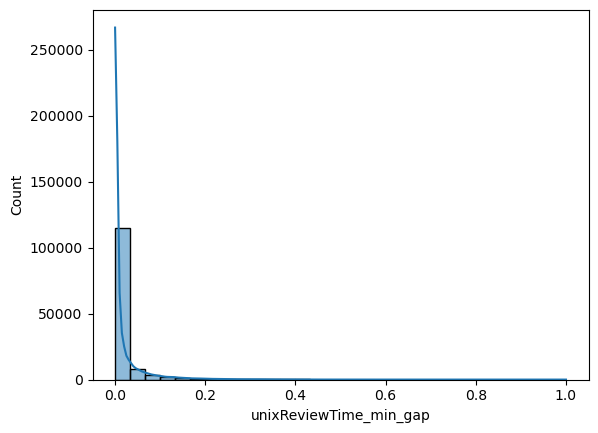

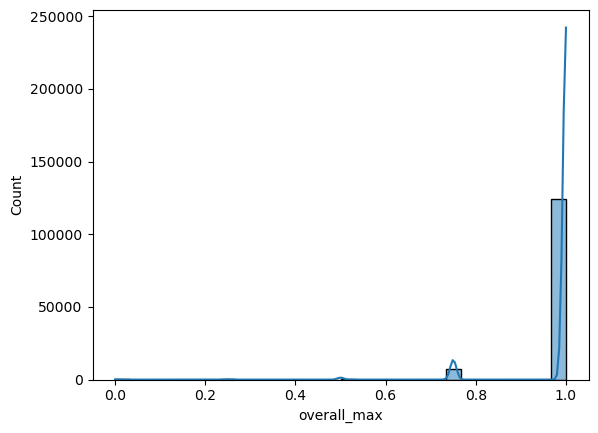

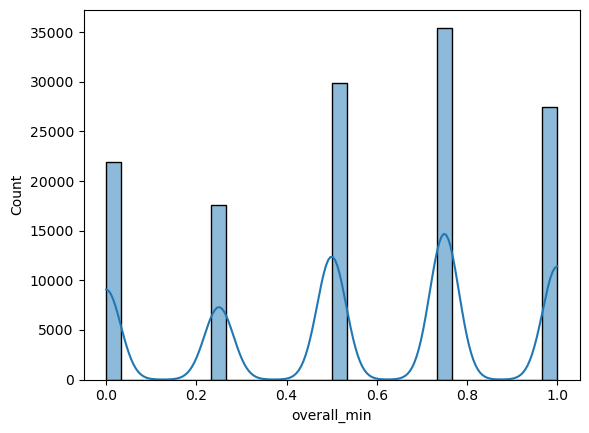

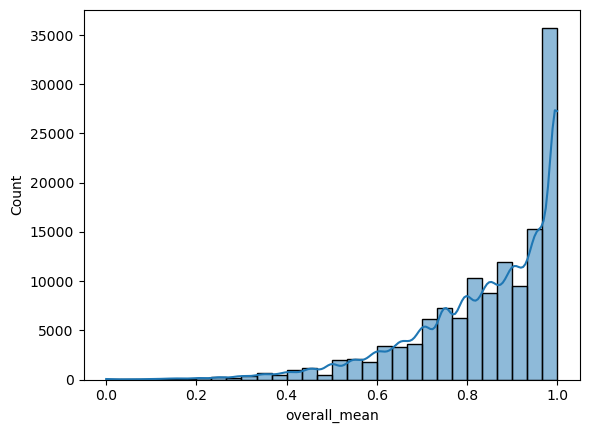

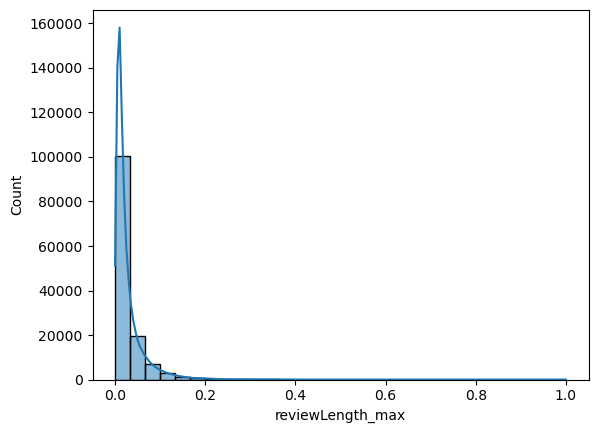

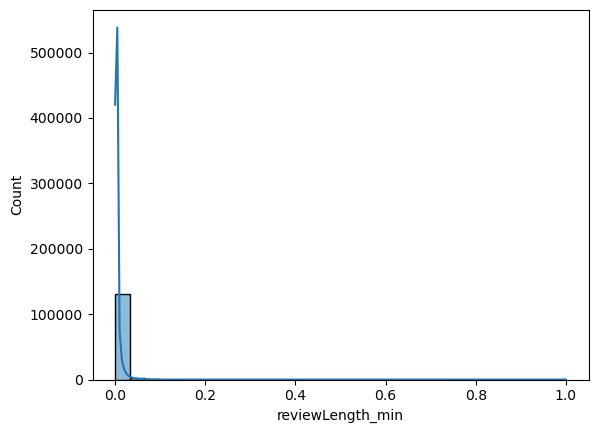

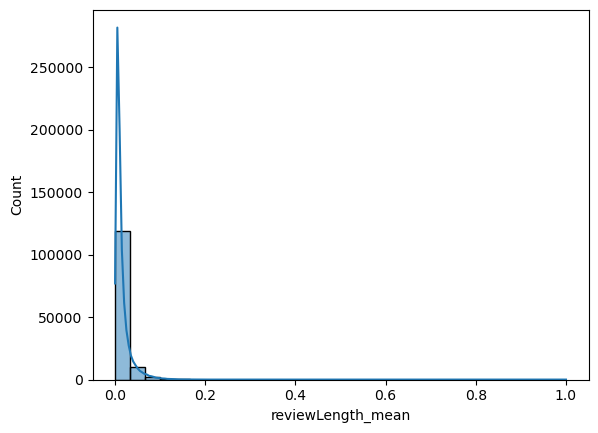

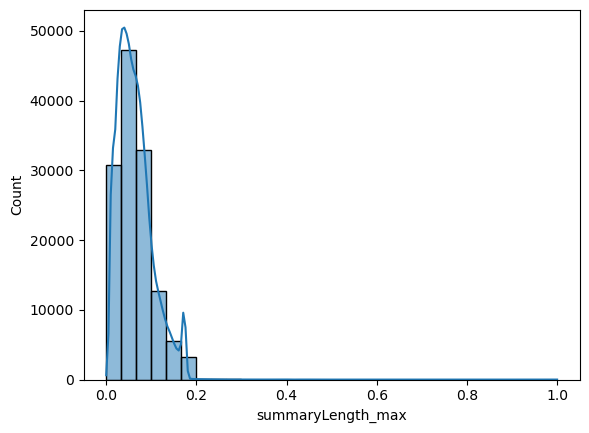

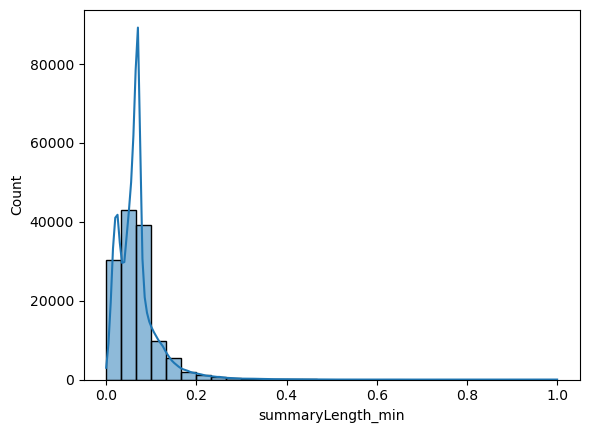

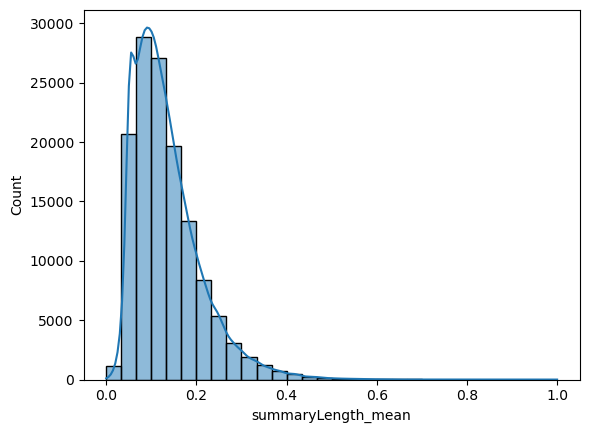

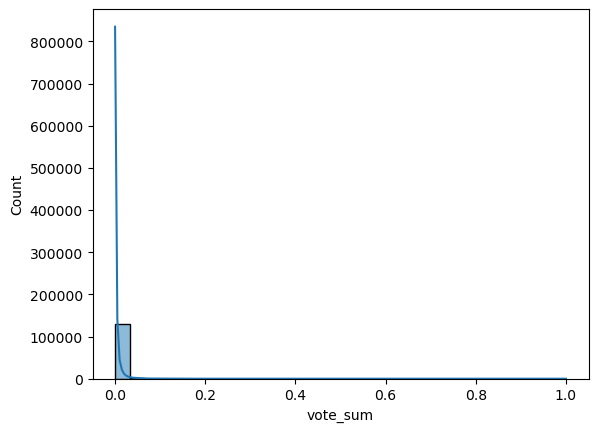

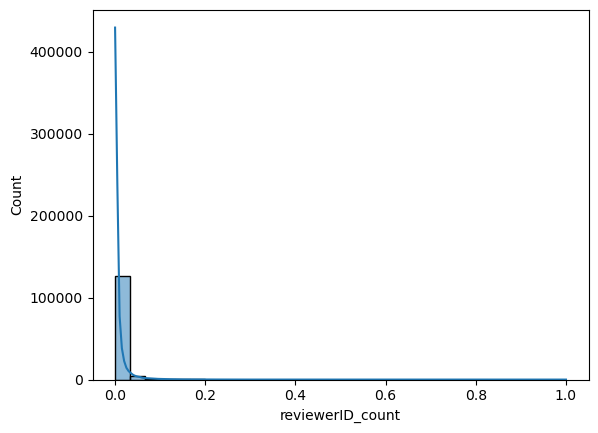

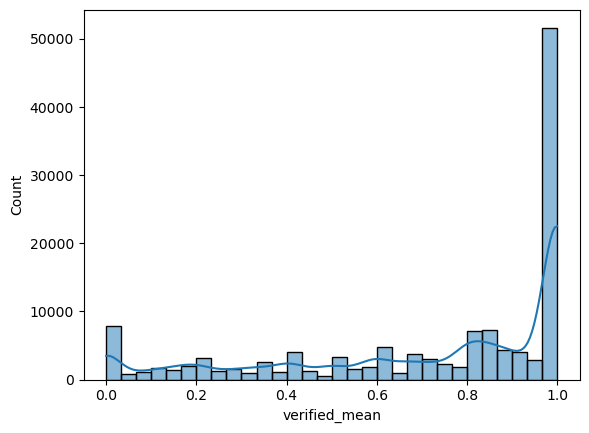

In [46]:
import seaborn as sns
for cols in df_scaled:
    plt.figure()
    sns.histplot(df_scaled[cols], kde=True, bins=30)

C:\Users\slopp\AppData\Local\Temp\ipykernel_15804\1611961542.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


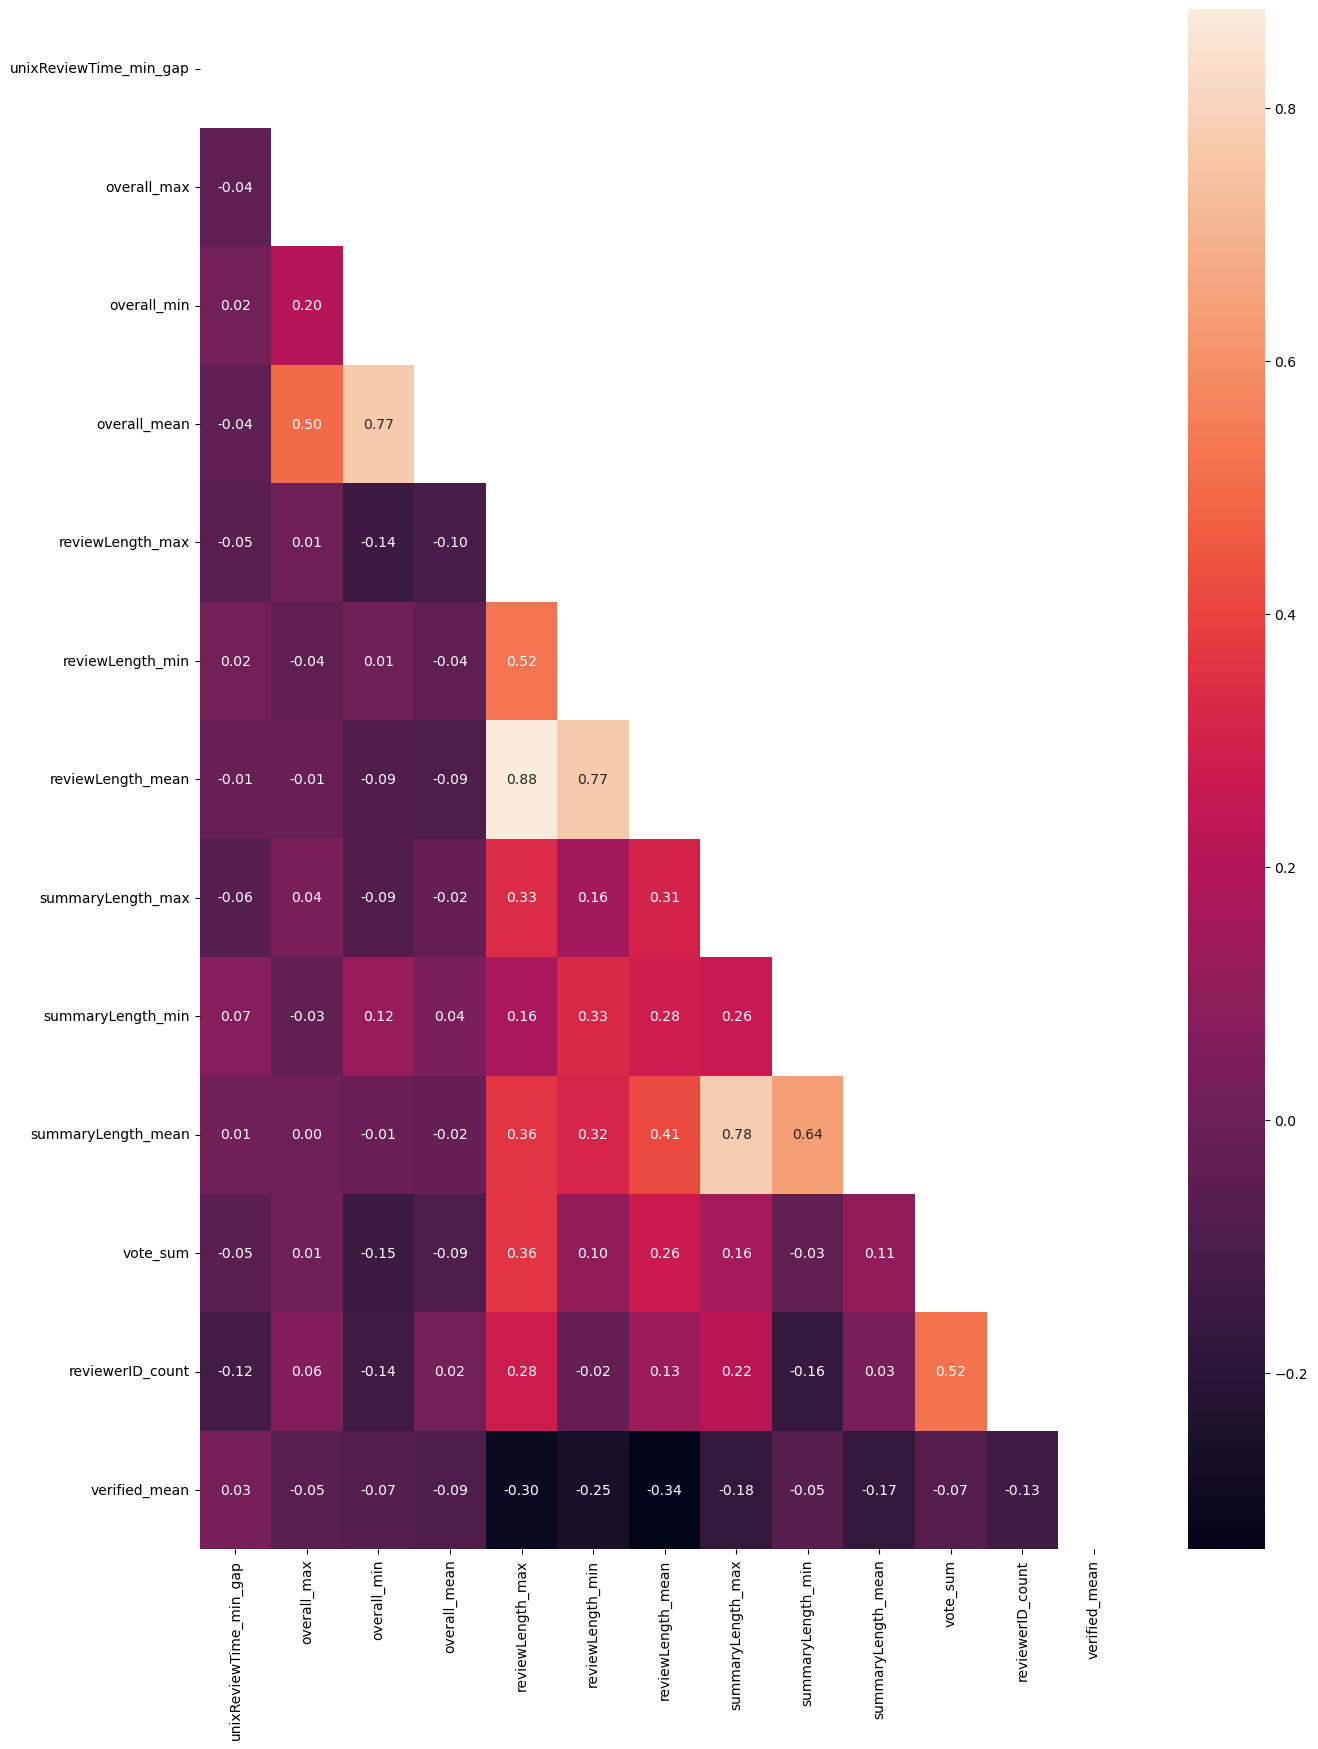

In [47]:
import numpy as np
corr = df_scaled.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True
plt.figure(figsize=(15,20))
sns.heatmap(corr,  annot=True, fmt=".2f", mask = mask)
plt.show()

High correlation between mins, maxes, and means. This is to be expected, but potentially problematic. I will revist this later Now, it's time to build our model. I will first construct a dendogram and experiment with cutoff points.

In [48]:
#import scipy.cluster.hierarchy as shc
#plt.figure()  
#plt.title("Dendrograms")  
#dend = shc.dendrogram(shc.linkage(df_scaled, method='ward'))
#MemoryError: Unable to allocate 65.3 GiB for an array with shape (8769051096,) and data type float64

Memory error! Dimensions are too large. Let's think of what to remove. First off, there is a high degree of correlation between min, max, and mean, which is to be expected. As such, I will remove all values of min and max unless they have a high standard deviation after scaling (which means they could tell us useful info). I will also remove unixReviewTime_mingap as it was kind of a failed experiment due to the fact that unix time is recorded on the day of review, not the second of the review. There is not much useful info there. I will remove all these variables then try again.

In [49]:
df_scaled2 = df_scaled.drop(columns=['unixReviewTime_min_gap', 'overall_max', 'reviewLength_max', 'reviewLength_min',
                                    'summaryLength_max', 'summaryLength_min'])
#import scipy.cluster.hierarchy as shc
#plt.figure()  
#plt.title("Dendrograms")  
#dend = shc.dendrogram(shc.linkage(df_scaled2, method='ward'))

In [50]:
import scipy.cluster.hierarchy as shc
import random
random.seed(0)
df_small = df_scaled.sample(frac=0.1, random_state=0)

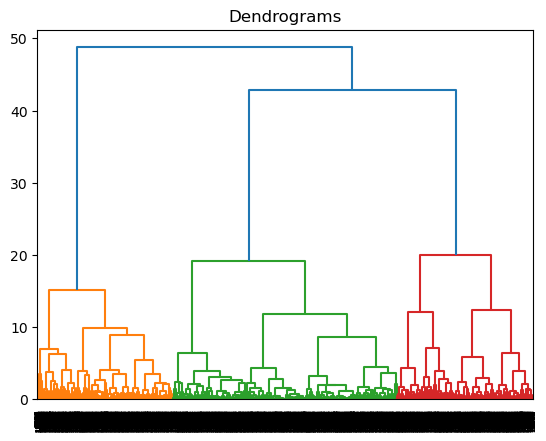

In [51]:
#https://stackoverflow.com/questions/67762297/memoryerror-unable-to-allocate-617-gib-for-an-array-with-shape-82754714206
random.seed(0)
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(df_small, method='ward'))

In [52]:
#%store dend
#% store -r dend to retrieve
#Not sure if this will be useful...

Stored 'dend' (dict)


In [53]:
#put a line at y=10: try 9 clusters
#put a line at ~y=16: try 5 clusters
#Put a line at y=30: try 3 clusters
random.seed(0)
df_small = df_scaled.sample(frac=0.3, random_state=0)

In [54]:
from sklearn.cluster import AgglomerativeClustering
#Unfortunately, we will need to work with a subset of our data again. 
#We again get a memory error requiring 65GB :O
#PERHAPS GO BACK AND DEFINE A LESS SMALL SUBSET?
random.seed(0)
cluster_3 = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
cluster_3.fit_predict(df_small)
cluster_5 = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')  
cluster_5.fit_predict(df_small)
cluster_9 = AgglomerativeClustering(n_clusters=9, affinity='euclidean', linkage='ward')  
cluster_9.fit_predict(df_small)
#%store cluster_3
#%store cluster_5
#%store cluster_9

Stored 'cluster_3' (AgglomerativeClustering)
Stored 'cluster_5' (AgglomerativeClustering)
Stored 'cluster_9' (AgglomerativeClustering)


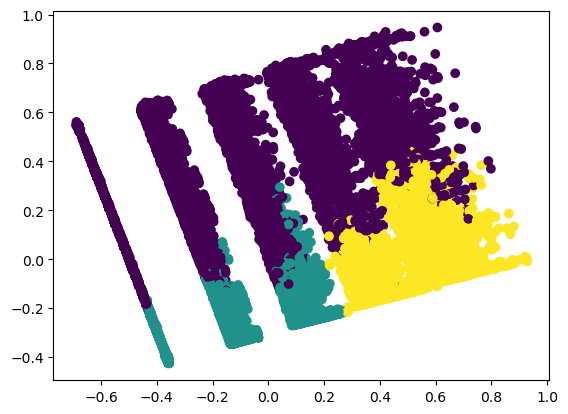

In [55]:
#I will also try to visualize using PCA
#https://machinelearningmastery.com/principal-component-analysis-for-visualization/
#https://www.kaggle.com/code/sabanasimbutt/clustering-visualization-of-clusters-using-pca#Visualization-of-Clusters
random.seed(0)
from sklearn.decomposition import PCA
%store -r cluster_3
pca = PCA(2) #2 components
X_pca = pca.fit_transform(df_small)
plot = plt.scatter(X_pca[:,0], X_pca[:,1], c=cluster_3.labels_)
plt.show()

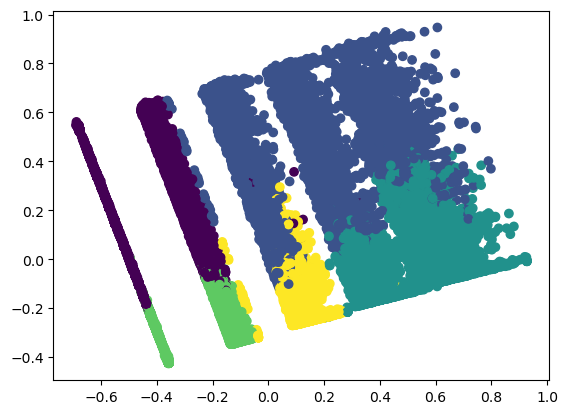

In [56]:
%store -r cluster_5
plot = plt.scatter(X_pca[:,0], X_pca[:,1], c=cluster_5.labels_)
plt.show()

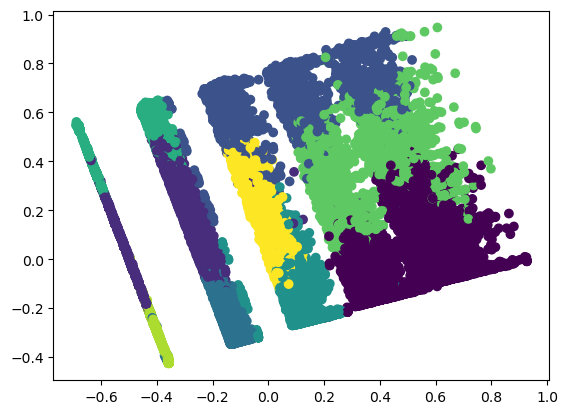

In [57]:
plot = plt.scatter(X_pca[:,0], X_pca[:,1], c=cluster_9.labels_)
plt.show()

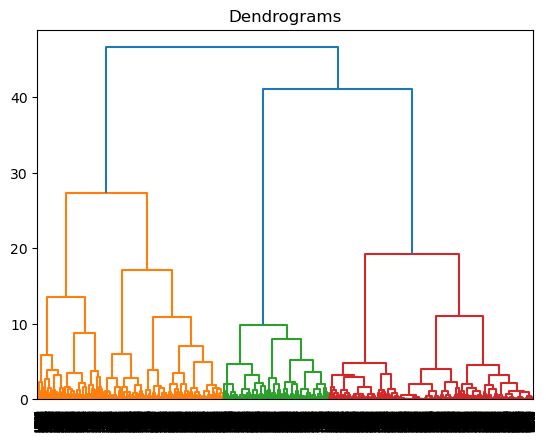

In [58]:
#try df_scaled2 with fewer predictors 
#This makes more sense as far as interpretability goes.
random.seed(0)
df_small2 = df_scaled2.sample(frac=0.1, random_state=0)
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(df_small2, method='ward'))

In [59]:
#put a line at y=10: try 9 clusters
#put a line at ~y=16: try 6 clusters
#Put a line at y=30: try 3 clusters

In [60]:
random.seed(0)
df_small2 = df_scaled2.sample(frac=0.3, random_state=0)
cluster2_3 = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
cluster2_3.fit_predict(df_small2)
cluster2_6 = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')  
cluster2_6.fit_predict(df_small2)
cluster2_9 = AgglomerativeClustering(n_clusters=9, affinity='euclidean', linkage='ward')  
cluster2_9.fit_predict(df_small2)
#%store cluster2_3
#%store cluster2_6
#%store cluster2_9

Stored 'cluster2_3' (AgglomerativeClustering)
Stored 'cluster2_6' (AgglomerativeClustering)
Stored 'cluster2_9' (AgglomerativeClustering)


['0' '1' '2' '3' '4' '5']


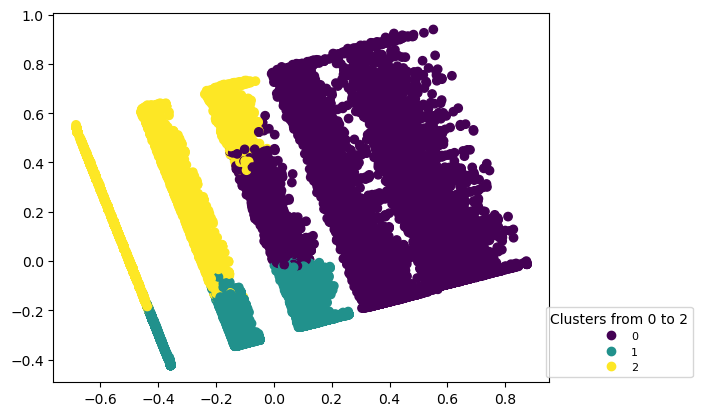

In [118]:
X_pca2 = pca.fit_transform(df_small2)
plot = plt.scatter(X_pca2[:,0], X_pca2[:,1], c=cluster2_3.labels_)
plt.legend(handles=plot.legend_elements(num=None)[0], 
            labels=['0','1','2'],
            loc="lower right", title="Clusters from 0 to 2", fontsize="8",
            bbox_to_anchor=(1.3, 0))
plt.show()

['0', '1', '2', '3', '4', '5']


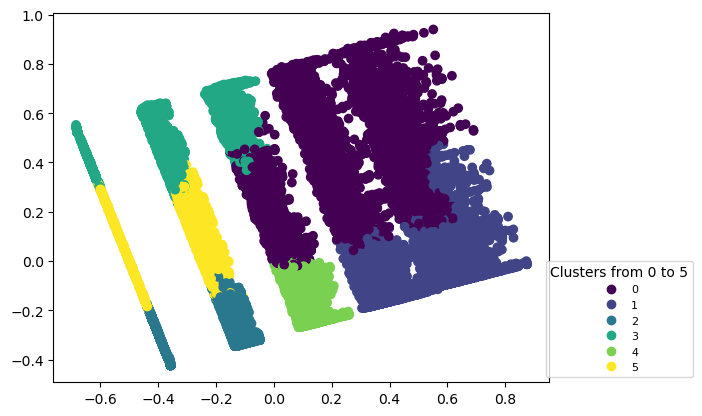

In [123]:
plot = plt.scatter(X_pca2[:,0], X_pca2[:,1], c=cluster2_6.labels_)
labels= list(map(str, np.unique(cluster2_6.labels_)))
plt.legend(handles=plot.legend_elements()[0],
                loc="lower right", title="Clusters from 0 to 5", fontsize="8",
               labels=labels,
          bbox_to_anchor=(1.3, 0))
plt.show()

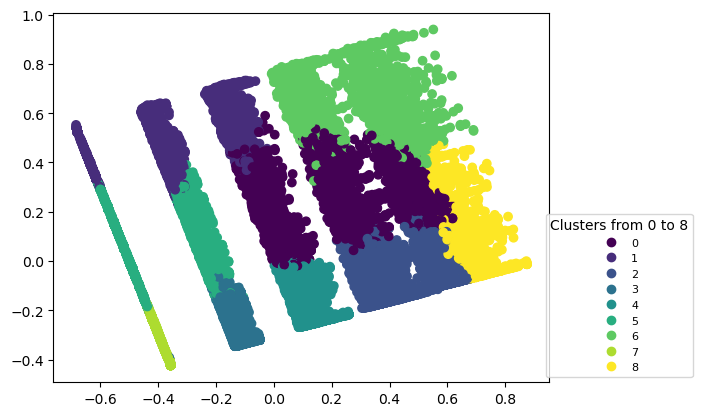

In [125]:
plot = plt.scatter(X_pca2[:,0], X_pca2[:,1], c=cluster2_9.labels_)
labels= list(map(str, np.unique(cluster2_9.labels_)))
plt.legend(handles=plot.legend_elements()[0],
                loc="lower right", title="Clusters from 0 to 8", fontsize="8",
                labels=labels,
                bbox_to_anchor=(1.3, 0))
plt.show()

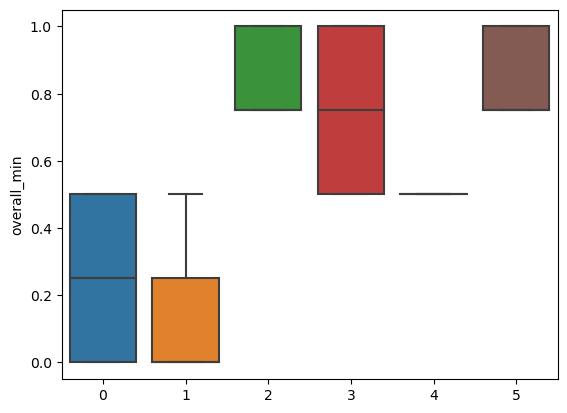

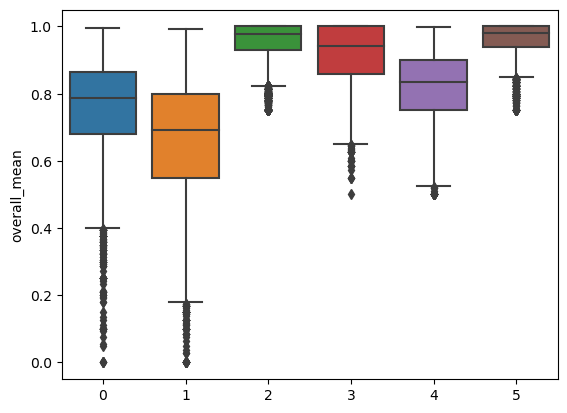

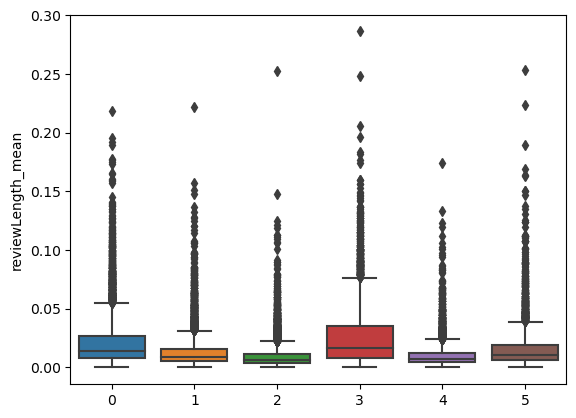

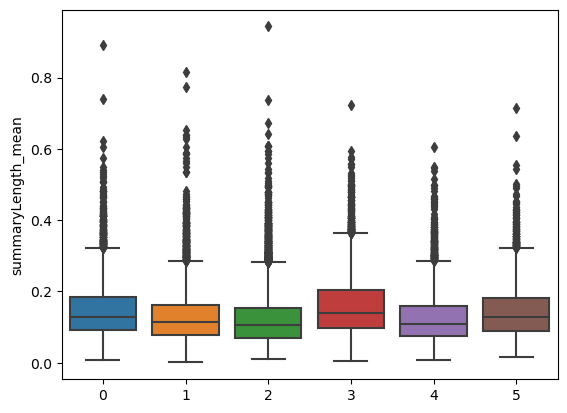

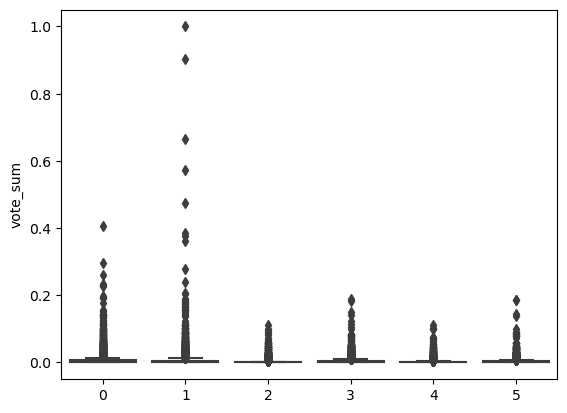

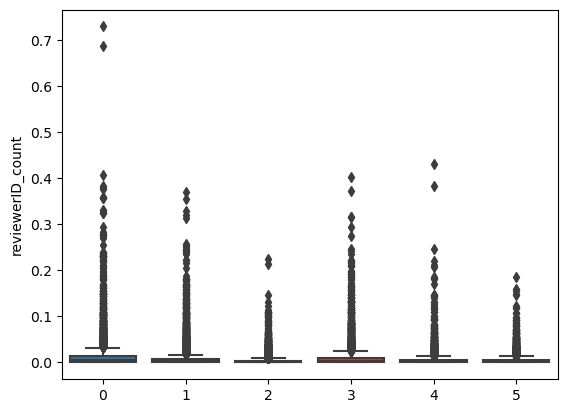

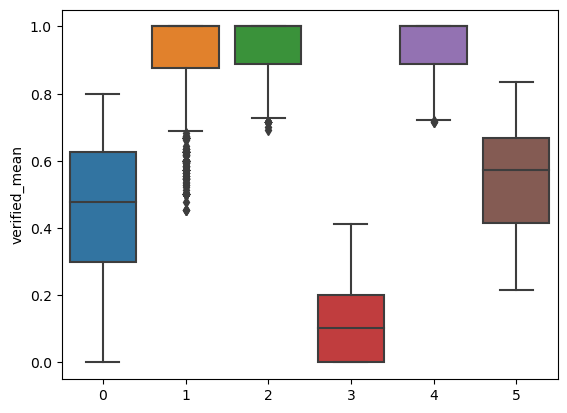

In [64]:
columns=df_small2.columns.tolist()
for cols in columns:
    plt.figure()
    sns.boxplot(x=cluster2_6.labels_,
                y=df_small2[cols])

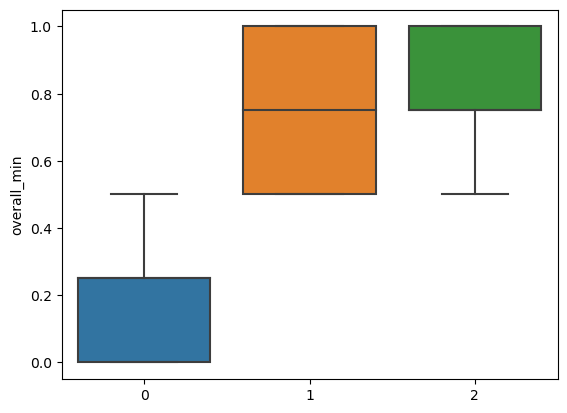

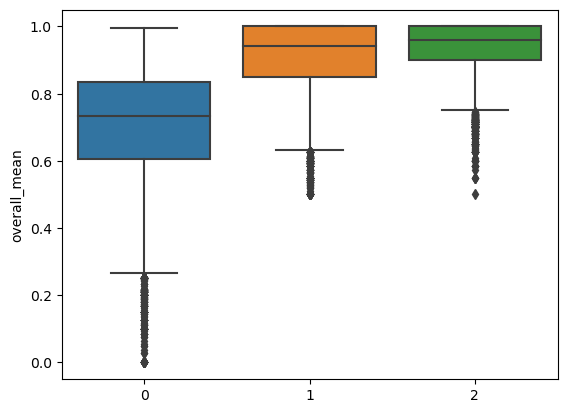

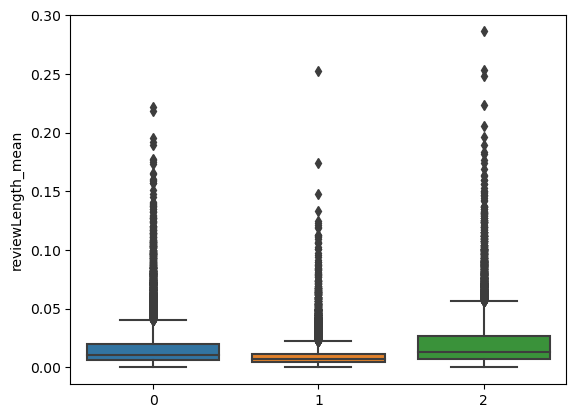

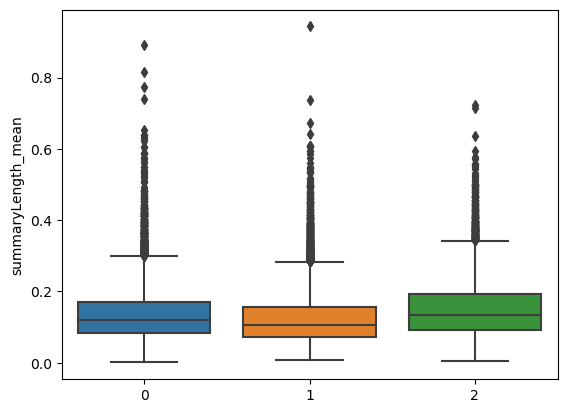

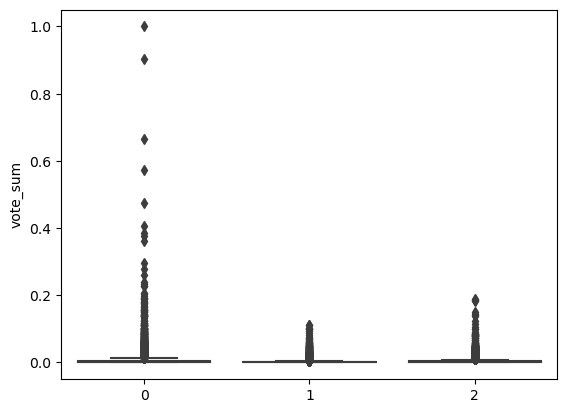

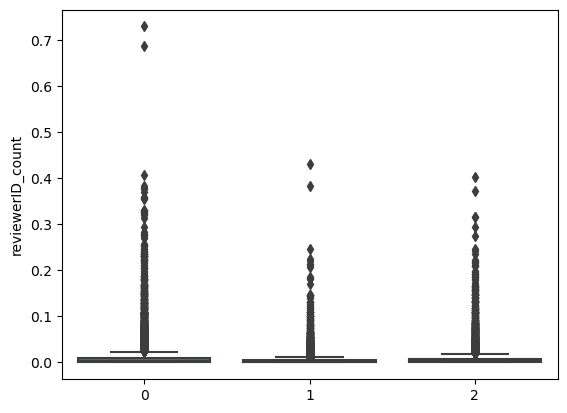

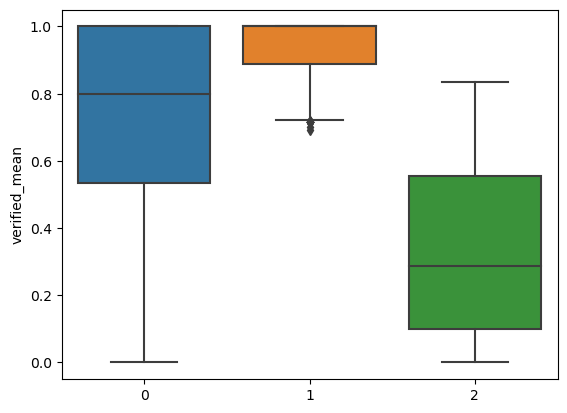

In [65]:
for cols in columns:
    plt.figure()
    sns.boxplot(x=cluster2_3.labels_,
                y=df_small2[cols])

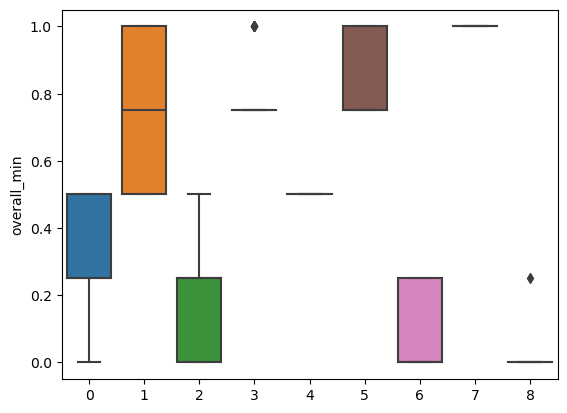

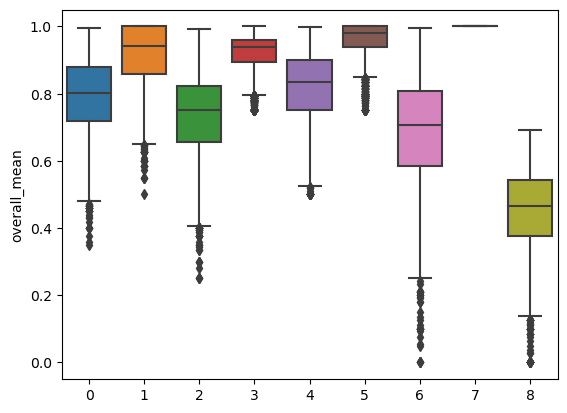

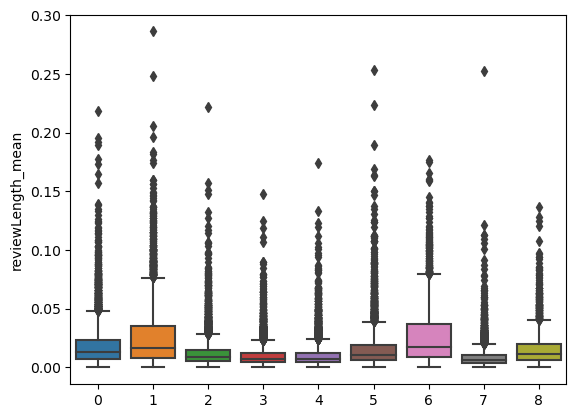

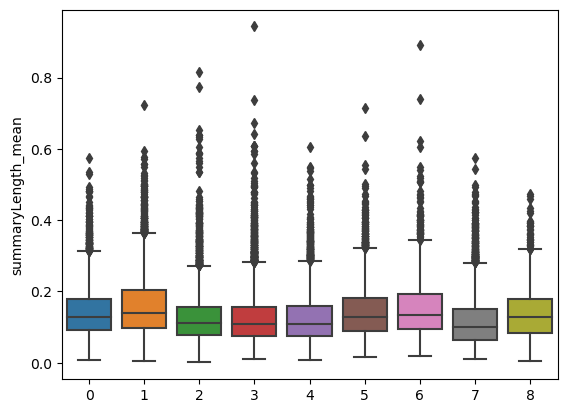

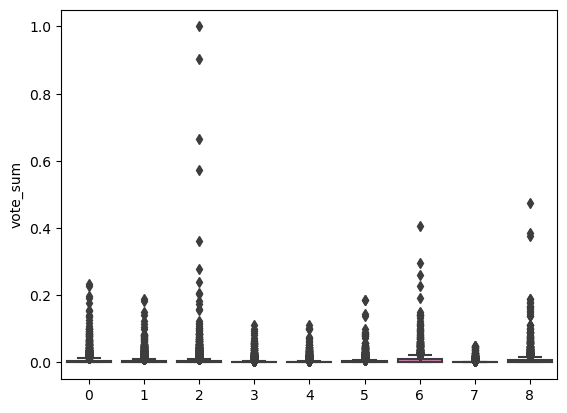

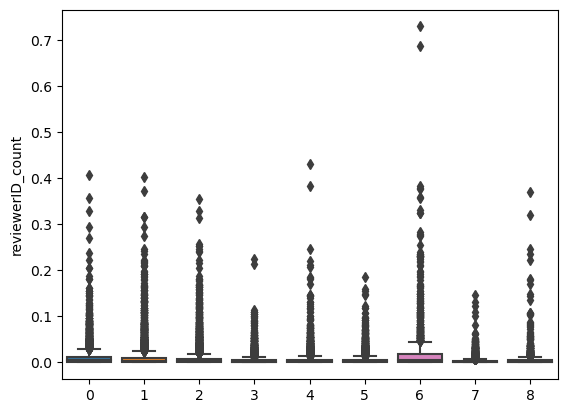

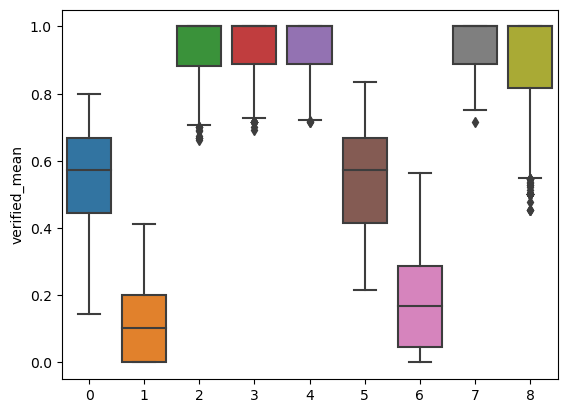

In [66]:
for cols in columns:
    plt.figure()
    sns.boxplot(x=cluster2_9.labels_,
                y=df_small2[cols])

In [68]:
from sklearn import metrics
silhouette_score = metrics.silhouette_score(df_small2, cluster2_3.labels_)
print(silhouette_score)

0.37509143190794214


In [69]:
silhouette_score = metrics.silhouette_score(df_small2, cluster2_6.labels_)
print(silhouette_score)

0.3320475282795616


In [70]:
silhouette_score = metrics.silhouette_score(df_small2, cluster2_9.labels_)
print(silhouette_score)

0.3455618720296621


In [71]:
#Seems to increase after 5, but still lower than 3. Just to check, I will try 20. (y=5 on the dendrogram)
cluster2_20 = AgglomerativeClustering(n_clusters=20, affinity='euclidean', linkage='ward')  
cluster2_20.fit_predict(df_small2)

0.3455618720296621


In [72]:
silhouette_score = metrics.silhouette_score(df_small2, cluster2_20.labels_)
print(silhouette_score)
#slightly lower.

0.3431780877906427


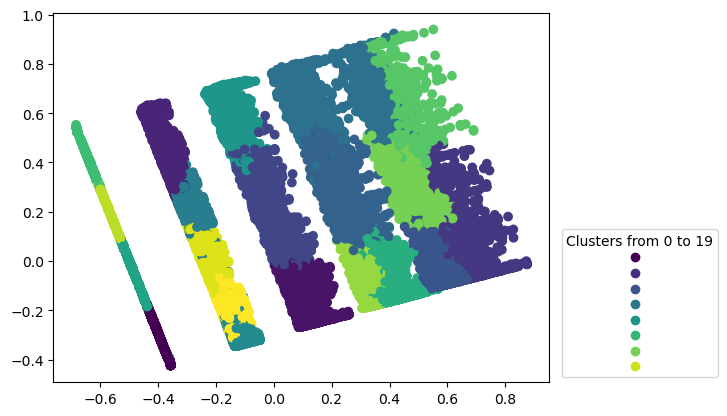

In [85]:
plot = plt.scatter(X_pca2[:,0], X_pca2[:,1], c=cluster2_20.labels_)
plt.legend(handles=plot.legend_elements()[0],
                loc="lower right", title="Clusters from 0 to 19", fontsize="8",
                bbox_to_anchor=(1.35, 0))
#ax.add_artist(legend1)
#handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
plt.show()
#PCA map is not helpful with so many clusters....
#additionally, side-by side boxplots will be messy. I think I will omit this from my analysis.